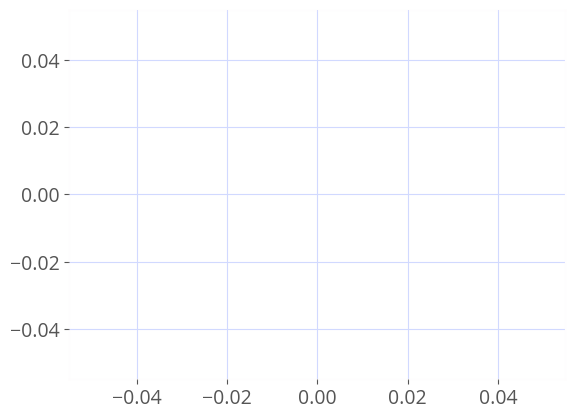

0-element Array{Any,1}

In [1]:
using DataFrames, CSV, PyPlot, PorousMaterials

PyPlot.matplotlib.font_manager.fontManager.addfont("OpenSans-Regular.ttf")
# PyPlot.matplotlib.font_manager.fontManager.addfont("Abel-Regular.ttf")
PyPlot.matplotlib.style.use("grandbudapest.mplstyle")

plot()

# methane adsorption HKUST-1 and MOF-5
read in adsorption data, covert uptake to mmol/g

In [2]:
mofs = ["HKUST-1", "MOF-5"]
df = Dict{String, DataFrame}()
for mof in mofs
    df[mof] = CSV.read(joinpath("..", "adsorption_data", "ch4_" * mof * "_25C.csv"), comment="#")
    df[mof][!, :m_mmol_g] = df[mof][:, Symbol("N(cm3/g)")] / 22.4
    df[mof][!, :g_g] = df[mof][!, :m_mmol_g] * 16.04 / 1000
end
first(df[mofs[1]], 3)

,P(bar),N(cm3/g),m_mmol_g,g_g
,Float64,Float64,Float64,Float64
1,0.68,15.52,0.692857,0.0111134
2,1.72,34.43,1.53705,0.0246543
3,3.55,62.79,2.80313,0.0449621


fit Langmuir model

In [3]:
params = Dict(mof => fit_adsorption_isotherm(df[mof], Symbol("P(bar)"), :g_g, :langmuir) for mof in mofs)

Dict{String,Dict{String,Float64}} with 2 entries:
  "MOF-5"   => Dict("M"=>0.517215,"K"=>0.0139932,"MSE"=>8.29801e-6)
  "HKUST-1" => Dict("M"=>0.267528,"K"=>0.0600262,"MSE"=>1.1954e-6)

In [4]:
f(p::Float64, mof::String) = params[mof]["M"] * params[mof]["K"] * p ./ (1 .+ params[mof]["K"] * p)
g(m::Float64, mof::String) = 1 / params[mof]["K"] * m / (params[mof]["M"] - m) # inverse

g (generic function with 1 method)

In [5]:
mof_to_color = Dict("MOF-5" => "C0", "HKUST-1" => "C1")

Dict{String,String} with 2 entries:
  "MOF-5"   => "C0"
  "HKUST-1" => "C1"

plot data with Langmuir fit

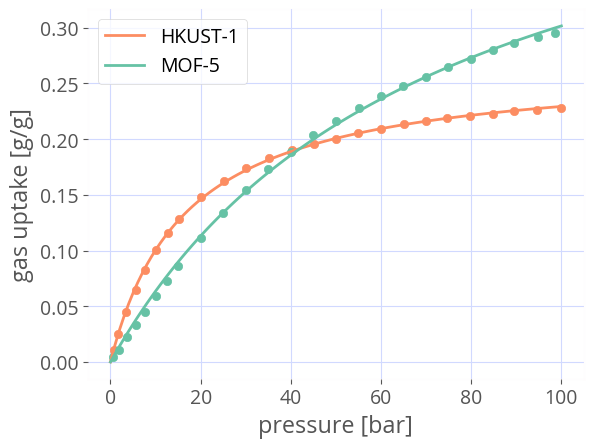

PyObject Text(34.0, 0.5, 'gas uptake [g/g]')

In [6]:
figure()
p = range(0.0, 100.0, length=100)
for mof in mofs
    scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :g_g], color=mof_to_color[mof])
    plot(p, f.(p, mof), label=mof, color=mof_to_color[mof])
end
legend()
xlabel("pressure [bar]")
ylabel("gas uptake [g/g]")

# illustrate $\delta m$

Rachel: put $\kappa(P)$ and $\kappa(m)$ for inverse problem here.

In [7]:
δm = 16.04 / 1000
δ_color = "C4"

"C4"

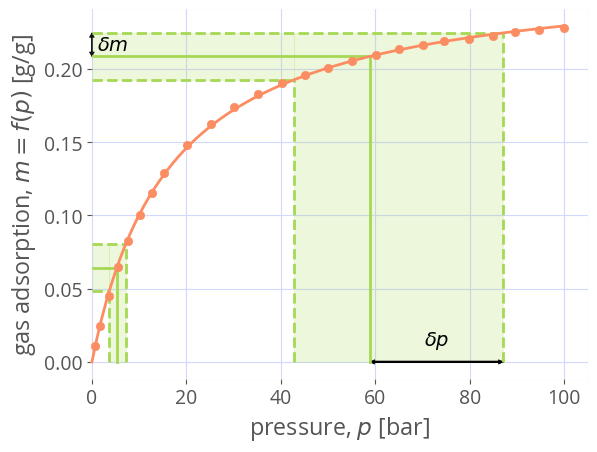

PyObject Text(38.000000000000014, 0.5, 'gas adsorption, $m=f(p)$ [g/g]')

In [8]:
ms = [4.0 * 16.04 / 1000, 13.0 * 16.04 / 1000]

figure()
p = range(0.0, 100.0, length=100)
mof = "HKUST-1"
scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :g_g], zorder=1000, 
    clip_on=false, color=mof_to_color[mof])
plot(p, params[mof]["M"] * params[mof]["K"] * p ./ (1 .+ params[mof]["K"] * p), 
    label=mof, zorder=1000, clip_on=false, color=mof_to_color[mof])
for (i, m) in enumerate(ms)
    p = g(m, mof)
    plot([p, p], [0, m], color=δ_color)
    plot([0, p], [m, m], color=δ_color)
    m_low = m - δm
    m_high = m + δm
    p_low = g(m_low, mof)
    p_high = g(m_high, mof)
    plot([p_low, p_low], [0, m_low], linestyle="--", color=δ_color)
    plot([0, p_low], [m_low, m_low], linestyle="--", color=δ_color)
    plot([p_high, p_high], [0, m_high], linestyle="--", color=δ_color)
    plot([0, p_high], [m_high, m_high], linestyle="--", color=δ_color)
    
    ps = range(p_low, p_high, length=200)
    fill_between(ps, [m_high for _ = 1:length(ps)], alpha=0.2, color=δ_color)
    fill_between([0.0, p_low], [m_low, m_low], [m_high, m_high], alpha=0.2, color=δ_color)
    if i == 2
        arrow_dx = 1
        arrow_dy = 0.2 * 0.015
        arrow(0.0, m, 0.0, δm, length_includes_head=true,
          head_width=arrow_dx, head_length=arrow_dy, clip_on=false, color="k")
        arrow(0.0, m+δm, 0.0, -δm, length_includes_head=true,
          head_width=arrow_dx, head_length=arrow_dy, clip_on=false, color="k")
        text(1.0, m + δm / 2, L"$\delta m$", verticalalignment="center")
        
        arrow(p, 0.0, p_high-p, 0.0, length_includes_head=true,
          head_width=arrow_dy, head_length=arrow_dx, clip_on=false, color="k")
        arrow(p_high, 0.0, p-p_high, 0.0, length_includes_head=true,
          head_width=arrow_dy, head_length=arrow_dx, clip_on=false, color="k")
        text(p + (p_high-p)/2, 0.75 * 0.015, L"$\delta p$", horizontalalignment="center")
    end
end

xlim(xmin=0.0)
#ylim([0.0, 20.0])
xlabel(L"pressure, $p$ [bar]")
ylabel(L"gas adsorption, $m=f(p)$ [g/g]")

For p̄ = 10.0 HKUST-1 δp = 2.829324672848088
For p̄ = 60.0 HKUST-1 δp = 29.20824612070176


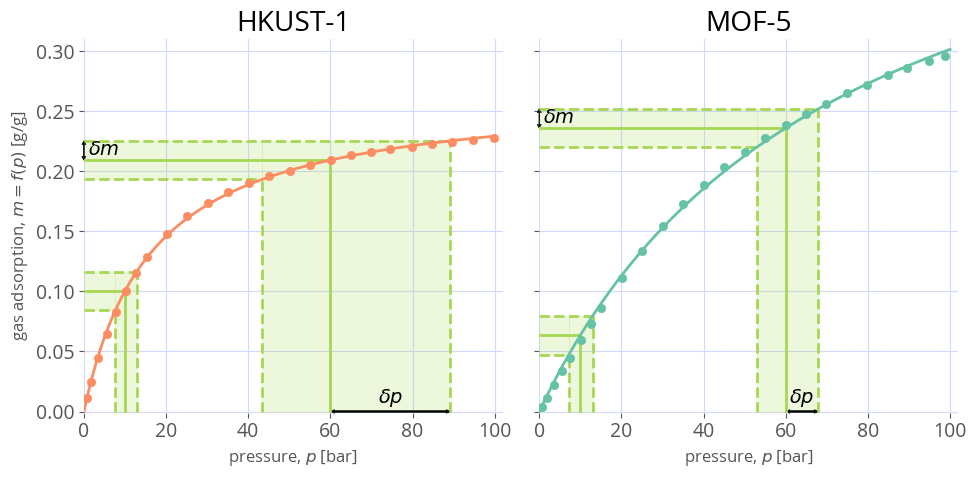

For p̄ = 10.0 MOF-5 δp = 2.985421448241649
For p̄ = 60.0 MOF-5 δp = 7.953723990842093


In [11]:
#figure 1
fig, axs = subplots(1, 2, figsize=(10, 5), sharey=true)
p = range(0.0, 100.0, length=100)
p̄ = [10.0, 60.0]
y_max = 0.31

for (i, mof) in enumerate(mofs)    
    axs[i].scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :g_g], 
        color=mof_to_color[mof], zorder=2003)
    axs[i].plot(p, f.(p, mof), color=mof_to_color[mof], zorder=1000)
    axs[i].set_title(mof)    
    
    for j in 1:2
        m̄ = f(p̄[j], mof)
        axs[i].plot([p̄[j], p̄[j]], [0, m̄], color=δ_color)
        axs[i].plot([0, p̄[j]], [m̄, m̄], color=δ_color)
    
        m_high = m̄ + δm
        p_high = g(m_high, mof)
        m_low = m̄ - δm
        p_low = g(m_low, mof)
        
        max_δp = max(p̄[j] - p_low, p_high - p̄[j])
        print("For p̄ = ", p̄[j], " ", mof, " δp = ", max_δp, '\n')
       
        axs[i].plot([p_low, p_low], [0, m_low], linestyle="--", color=δ_color)
        axs[i].plot([0, p_low], [m_low, m_low], linestyle="--", color=δ_color)
        axs[i].plot([p_high, p_high], [0, m_high], linestyle="--", color=δ_color)
        axs[i].plot([0, p_high], [m_high, m_high], linestyle="--", color=δ_color)
    
        ps = range(p_low, p_high, length=200)
        axs[i].fill_between(ps, [m_high for _ = 1:length(ps)], alpha=0.2, color=δ_color)
        axs[i].fill_between([0.0, p_low], [m_low, m_low], [m_high, m_high], alpha=0.2, color=δ_color)
        if j == 2
            arrow_dx = 1
            arrow_dy = 0.2 * 0.015
            axs[i].arrow(0.0, m̄, 0.0, δm, length_includes_head=true,
              head_width=arrow_dx, head_length=arrow_dy, clip_on=false, color="k")
            axs[i].arrow(0.0, m̄+δm, 0.0, -δm, length_includes_head=true,
              head_width=arrow_dx, head_length=arrow_dy, clip_on=false, color="k")
            axs[i].text(1.0, m̄ + δm / 2, L"$\delta m$", verticalalignment="center")

            axs[i].arrow(p̄[j], 0.0, p_high-p̄[j], 0.0, length_includes_head=true,
              head_width=arrow_dy, head_length=arrow_dx, clip_on=false, color="k")
            axs[i].arrow(p_high, 0.0, p̄[j]-p_high, 0.0, length_includes_head=true,
              head_width=arrow_dy, head_length=arrow_dx, clip_on=false, color="k")
            axs[i].text(p̄[j] + (p_high-p̄[j])/2, 0.5 * 0.015, L"$\delta p$", horizontalalignment="center")
            axs[i].set_xlabel(L"pressure, $p$ [bar]", fontsize=12)
        end 
    end 
    axs[i].set_xlim([0, 102])
    axs[i].set_ylim([-0.001, y_max])
end
axs[1].set_ylabel(L"gas adsorption, $m=f(p)$ [g/g]", fontsize=12)
tight_layout()




# $\kappa(p)$

In [9]:
#absolute error in predicted gas comp. over absolute error in data
κ_of_m(m::Float64) = params[mof]["M"] / (params[mof]["K"] * (params[mof]["M"] - m)^2)  # inverse kappa with respect to m
κ_of_p(p::Float64) = (1 + params[mof]["K"] * p)^2 / (params[mof]["K"] * params[mof]["M"]) # inverse kappa with respect to p   

κ_of_p (generic function with 1 method)

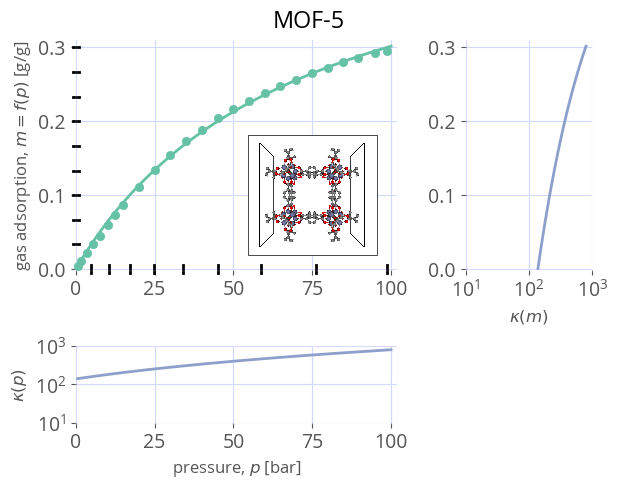

In [12]:
#figure 2
p = range(0.0, 100.0, length=100)

#mof = "HKUST-1"
mof = "MOF-5"

fig = figure()
ax1 = subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
ax2 = subplot2grid((3, 3), (0, 2), colspan=1, rowspan=2)
ax3 = subplot2grid((3, 3), (2, 0), colspan=2, rowspan=1)
tight_layout()

ax1.plot(p, f.(p, mof), color=mof_to_color[mof])
ax1.scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :g_g], zorder=1000, 
    clip_on=false, color=mof_to_color[mof])
ax2.plot(κ_of_m.(f.(p, mof)), f.(p, mof), color="C2")
ax3.plot(p, κ_of_p.(p), color="C2")

ax1.set_ylabel(L"gas adsorption, $m=f(p)$ [g/g]", fontsize=12)

ax3.set_xlabel(L"pressure, $p$ [bar]", fontsize=12)
ax3.set_ylabel(L"$κ(p)$", fontsize=12)
ax2.set_xlabel(L"$κ(m)$", fontsize=12)

ax1.set_ylim(-0.001,y_max)
ax2.set_ylim(-0.001,y_max)
ax1.set_xlim(0,102)
ax3.set_xlim(0,102)
ax2.set_xscale("log")
ax3.set_yscale("log")
ax2.set_xticks([10,100,1000])
ax3.set_yticks([10,100,1000])
suptitle(mof, y=1.02)
#make sure axes are same for above plots

#add ticks to plot
num_ticks = 10
m_ticks = range(0, 0.3, length=num_ticks)
for i = 1:num_ticks
    if i == 1 
        continue
    end
    ax1.plot([-1,1], [m_ticks[i], m_ticks[i]], color="black", clip_on=false)
    p = g(m_ticks[i], mof)
    ax1.plot([p,p], [-2/100 *0.3, 2/100 *0.3], color="black", clip_on=false)
end

#Add png to plot
mof_fig = imread(joinpath("..", "$mof.png"))
imagebox = PyPlot.matplotlib.offsetbox.OffsetImage(mof_fig, zoom=0.08, filternorm=100.0)
ab = PyPlot.matplotlib.offsetbox.AnnotationBbox(imagebox, (75.0, .10))
ax1.add_artist(ab)
tight_layout()
savefig("$mof.pdf", format="pdf")

In [13]:
κ_of_p.(100.0)

795.4044919300595

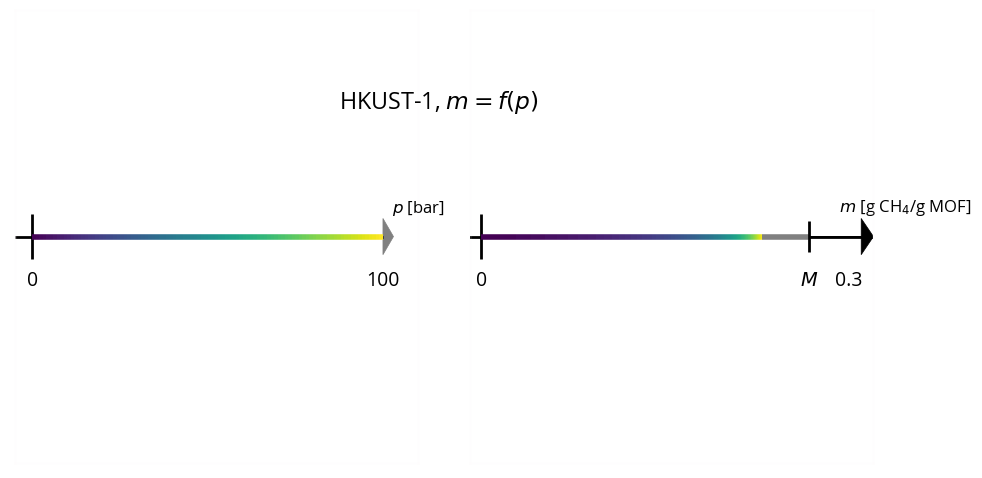

In [15]:
mof = "HKUST-1"

fig, axs = subplots(1, 2, figsize=(10, 5), sharey=true)

# Set up line segment with arrow head
bar_height = 1
axs[1].set_xlim(-5, 110)
axs[1].arrow(0.0, 0.0, 100.0, 0.0, head_width=0.8, head_length=3, color="grey")
axs[1].text(100, -bar_height * 1.1, 100, horizontalalignment="center")
axs[2].set_xlim(-0.009, 0.32)
axs[2].arrow(0.0, 0.0, 0.31, 0.0, head_width=0.8, head_length=0.01, color="black")
axs[2].text(0.3, -bar_height * 1.1, 0.3, horizontalalignment="center")
for i = 1:2 
    axs[i].set_ylim(-5, 5)
    axs[i].hlines(0.0, -5, 100)
    axs[i].axes.xaxis.set_ticks([])
    axs[i].axes.yaxis.set_ticks([])
    axs[i].vlines(0, - bar_height / 2., bar_height / 2., lw=2)
    axs[i].text(0, -bar_height * 1.1, 0, horizontalalignment="center")
end

# Set axes labels
axs[1].set_ylabel(L"$p$ [bar]", fontsize=12, rotation=0, color="black")
axs[1].yaxis.set_label_coords(1.0, 0.54)
axs[2].set_ylabel(L"$m$ [g CH$_4$/g MOF]", fontsize=12, rotation=0, color="black")
axs[2].yaxis.set_label_coords(1.08, 0.54)

# Set colors on p 
n_lines = 100
pressures = range(0.0, 100.0, length=n_lines+1)
colors = plt.cm.viridis.(range(0, 1, length=n_lines))
for i = 1:n_lines
    axs[1].hlines(0.0, pressures[i], pressures[i+1], color=colors[i], linewidth=4)
    m_min = f(pressures[i], mof)
    m_max = f(pressures[i+1], mof)
    axs[2].hlines(0.0, m_min, m_max, color=colors[i], clip_on=false, linewidth=4)
end
axs[2].hlines(0.0, f(pressures[n_lines], mof), params[mof]["M"], color="grey", clip_on=false, linewidth=4)

axs[2].vlines(params[mof]["M"], - bar_height / 3.0, bar_height / 3.0, lw=2)
axs[2].text(params[mof]["M"], -bar_height * 1.1, L"$M$", horizontalalignment="center")
suptitle(mof * L", $m = f(p)$", x=0.45, y=0.8)
plt.tight_layout()